In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
from sklearn import svm

In [ ]:
# Máme dataset ručně psaných číslic (cifry 0,1,2,3)
# Chceme vytrénovat vlastní model, který bude schopen číslice klasifikovat do tříd.
# Každá cifra je 8x8 pixelů (64 dimenzí?) v odstínách šedi.

# 1. Načtení datasetu
# 2. Flat matice na vektor (a vydělit 255?)
# 3. Použít logistickou regresi, OVR a K-N means algoritmus

In [ ]:
from scipy import optimize


class OneVsRest:
    def fit(self, X, y):
        pass

    def predict(self, X):
        pass

    def __str__(self):
        return "OVR"

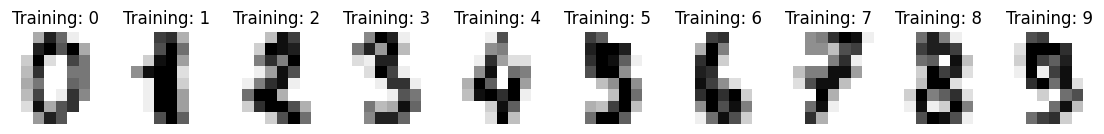

In [ ]:
# Načtení dat

digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(14, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [ ]:
# Scikit-learn řešení

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.5, shuffle=False)

clf = svm.SVC(gamma=0.001)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(f"Classification report for classifier {clf}:\n" f"{metrics.classification_report(y_test, predicted)}\n")

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




C:\Temp\ipykernel_10084\359608127.py:27: RuntimeWarning: divide by zero encountered in log
  + (1 + self._y).T @ np.log(1 - self.sigmoida(w, self._X))
c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


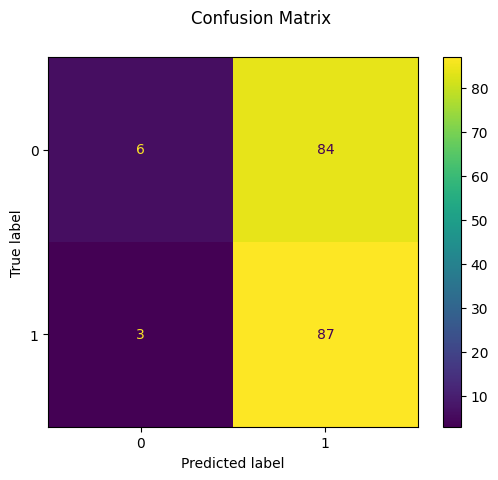

In [ ]:
# Logistická regrese binární řešení

class naivni_logisticka_regrese_binarni:
    def __init__(self):
        self._w = None
        self._X = None
        self._y = None
        self._regularization = False

    def sigmoida(self, w, X):
        return 1.0 / (1.0 + np.exp(-X @ w))

    def kriterialni_funkce_bez_regularizace(self, w):
        return -(self._y.T @ np.log(self.sigmoida(w, self._X)) + (1 + self._y).T @ np.log(1 - self.sigmoida(w, self._X)))

    def kriterialni_funkce_s_regularizaci(self, w):
        return self.kriterialni_funkce_bez_regularizace(w) + self._c * np.sum(w**2)

    def fit(self, X, y, c=0.001, regularization=False):
        self._c = c
        self._regularization = regularization

        dimenze = X.shape[1] + 1
        radky = X.shape[0]
        # priprav si data - pridani sloupce se jednickami, pro bias
        self._X = np.hstack((np.ones((radky, 1)), X))  # pridej jednicky
        self._y = y
        # je pouzita iteracni metoda optimalizace, nahodne je zvolena nulta iterace
        w0 = np.random.randn(dimenze)  # nahodny bod
        self._w = w0

        res = optimize.minimize(self.kriterialni_funkce_s_regularizaci if regularization else self.kriterialni_funkce_bez_regularizace, w0, method="BFGS", tol=1e-5)

        self._w = res.x
        return self._w

    def predict_proba(self, X):
        return self.sigmoida(self._w, np.hstack((np.ones((X.shape[0], 1)), X)))

    def predict(self, X, hranice=0.5):
        pravdepodobnost = self.predict_proba(X)
        return 1 * (pravdepodobnost > hranice)

digits = datasets.load_digits()

mask = (digits.target == 0) | (digits.target == 1)
X = digits.images[mask].reshape((np.sum(mask), -1))
y = digits.target[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

model = naivni_logisticka_regrese_binarni()
model.fit(X_train, y_train, c=0.001, regularization=False)
predicted = model.predict(X_test)

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

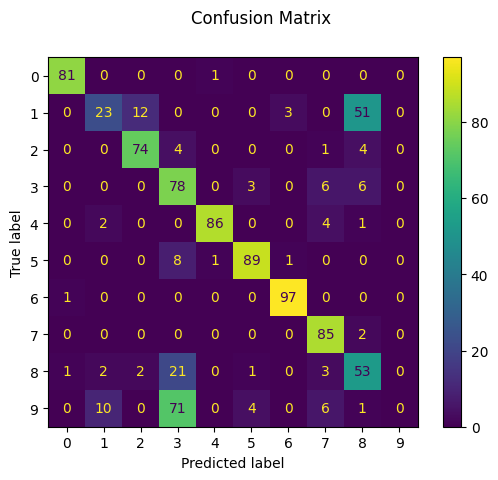

In [ ]:
# K-means řešení

class KMeansClassifier:
    def __init__(self, k=10, max_iterations=1000):
        self.k = k
        self.max_iterations = max_iterations
        self.centroids = None
        self.label_mapping = {}

    def _k_means(self, X, k, max_iterations=1000):
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]
        for _ in range(max_iterations):
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            y = np.argmin(distances, axis=1)
            centroids_new = np.array([X[y == i].mean(axis=0) for i in range(k)])
            if np.allclose(centroids, centroids_new):
                break
            centroids = centroids_new
        return centroids, y

    def fit(self, X, y):
        # Provedeme k-means clustering na trénovacích datech
        self.centroids, cluster_assignments = self._k_means(X, self.k, self.max_iterations)
        # Pro každý cluster určíme, která třída se v něm vyskytuje nejčastěji
        for i in range(self.k):
            mask = (cluster_assignments == i)
            if np.sum(mask) <= 0:
                continue
            # Vezmeme většinový hlas pro daný cluster
            majority_label = np.bincount(y[mask]).argmax()
            self.label_mapping[i] = majority_label
        return self

    def predict(self, X):
        # Pro každý vzorek najdeme nejbližší centroid a přiřadíme odpovídající třídu
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        cluster_assignments = np.argmin(distances, axis=1)
        predictions = np.array([self.label_mapping[c] for c in cluster_assignments])
        return predictions


# Načtení datasetu ručně psaných číslic (všechny třídy 0-9)
digits = datasets.load_digits()
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Rozdělení dat na trénovací a testovací sadu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

# Trénink modelu s k=10 (10 tříd)
model_kmeans = KMeansClassifier(k=10, max_iterations=1000)
model_kmeans.fit(X_train, y_train)
predicted_kmeans = model_kmeans.predict(X_test)

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_kmeans)
disp.figure_.suptitle("Confusion Matrix")
plt.show()